Importing the Dependencies

In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
 


Data Collection and Processing

In [374]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('train.csv')

In [375]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [376]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [377]:
# getting some information about thye dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [378]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Handling Missing Values

Mean --> average

Mode --> more repeated value

In [379]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

12.857645184136183

In [380]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [381]:
# mode of "Outlet_Size" column
big_mart_data['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [382]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [383]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [384]:
miss_values = big_mart_data['Outlet_Size'].isnull()   

In [385]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [386]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [387]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Data Analysis

In [388]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [389]:
sns.set()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


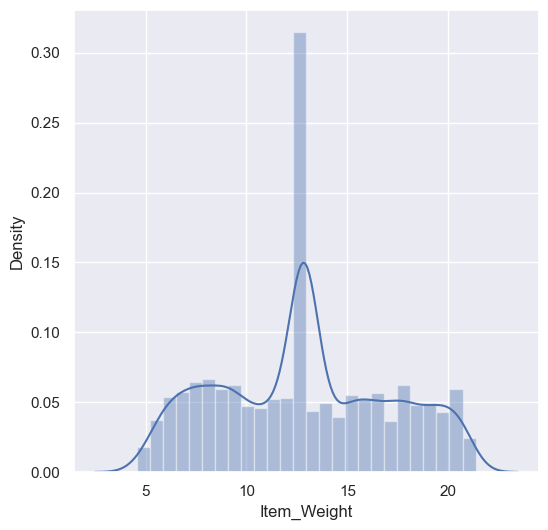

In [392]:
# Item_Weight distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


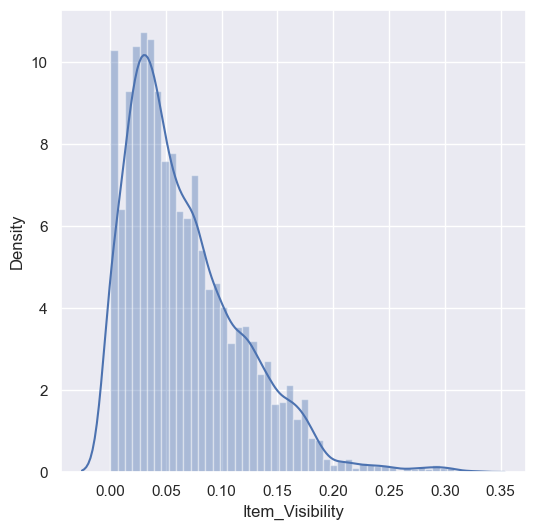

In [393]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


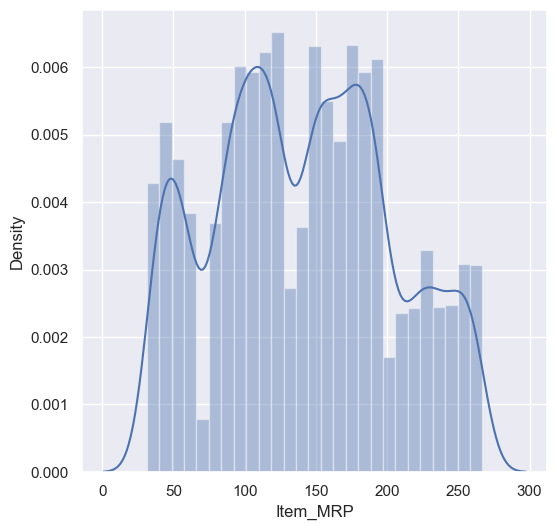

In [394]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


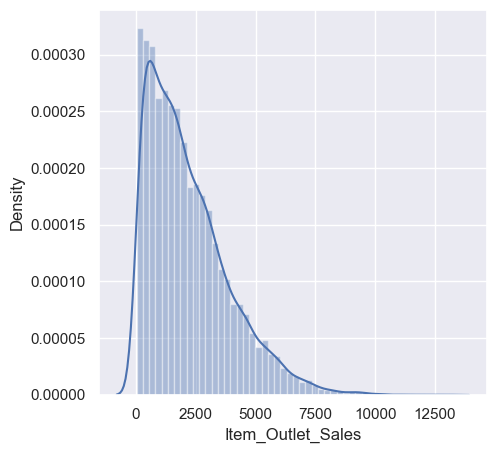

In [395]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(5,5))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

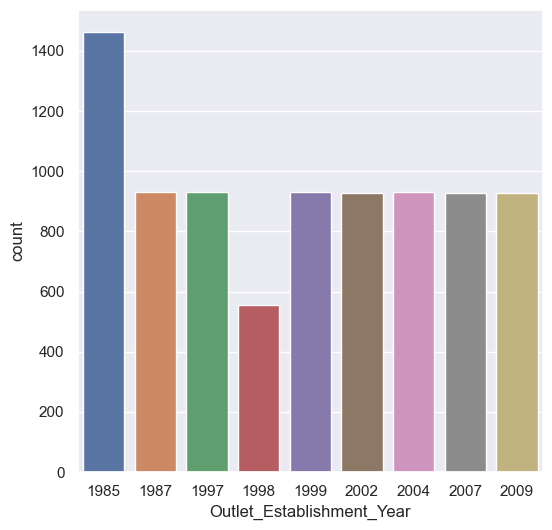

In [396]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

Categorical Features

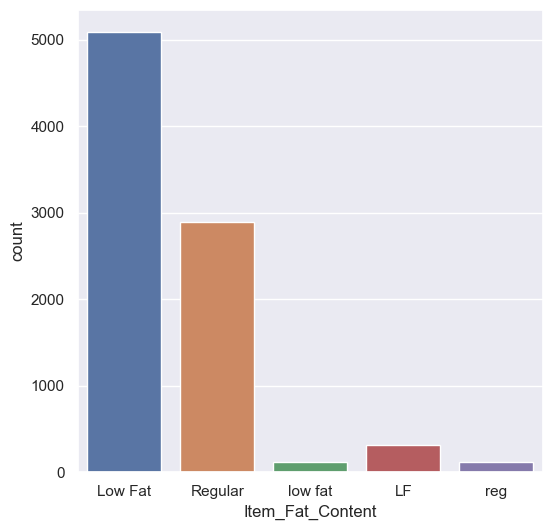

In [397]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

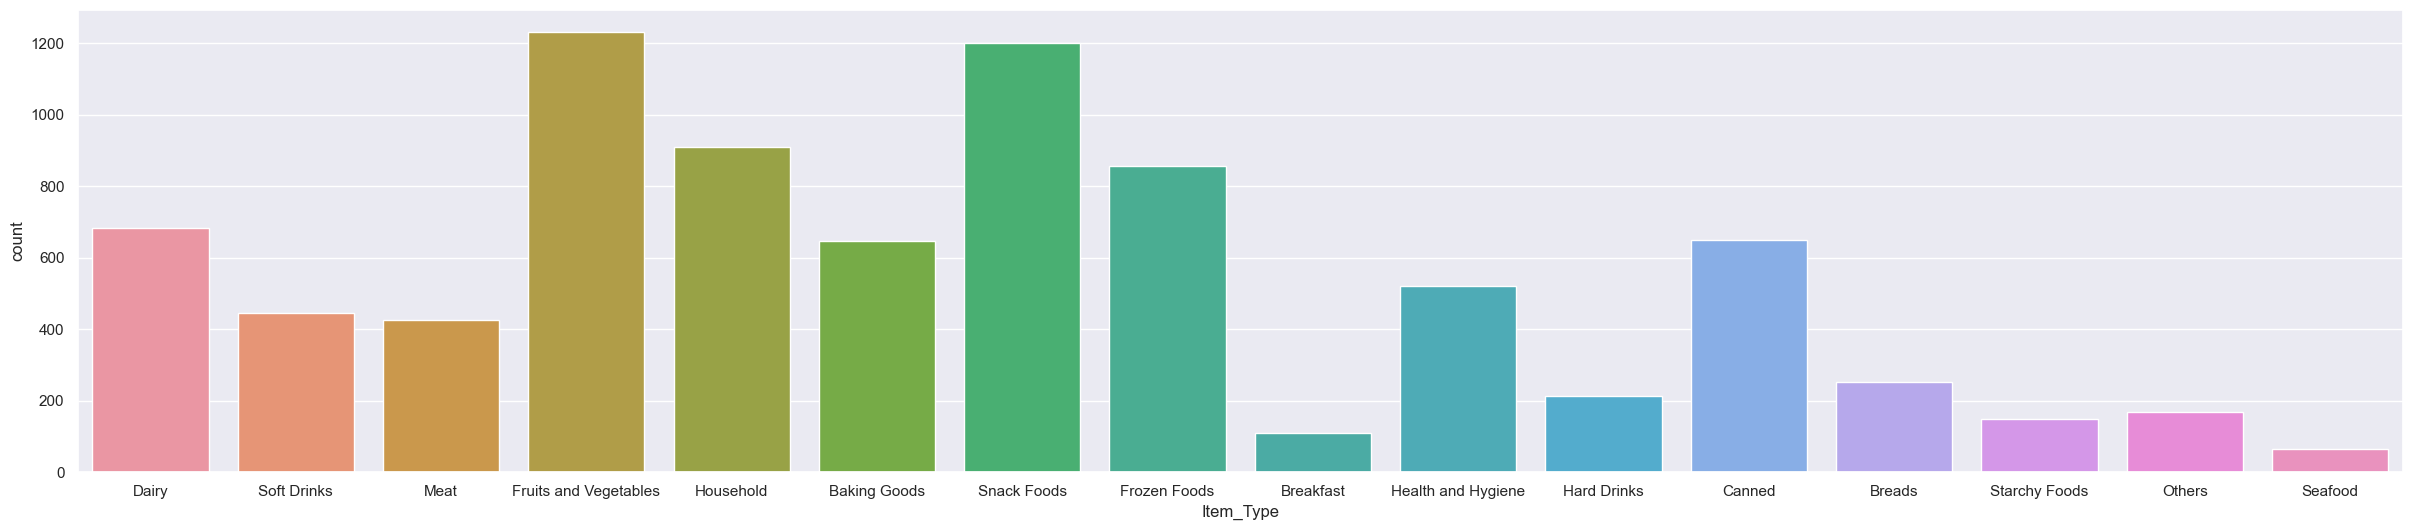

In [398]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

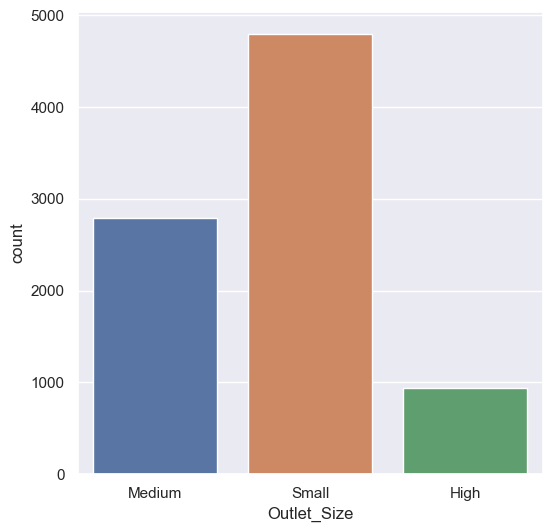

In [399]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

Data Pre-Processing

In [400]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [401]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [402]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [403]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Label Encoding

In [404]:
encoder = LabelEncoder()

In [405]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [406]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


Splitting features and Target

In [407]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [408]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [409]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


Splitting the data into Training data & Testing Data

In [410]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [411]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


Machine Learning Model Training

XGBoost Regressor

In [412]:

regressor = XGBRegressor()



In [413]:
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluation

In [414]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [415]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [416]:
print('R Squared value = ', r2_train)

R Squared value =  0.8639680373364909


In [417]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [418]:
# R squared Value
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [419]:
print('R Squared value = ', r2_test)

R Squared value =  0.5233136709735687


In [420]:
#Linear Regression
Lin_reg = LinearRegression()

Lin_reg.fit(X_train,Y_train)

y_pred = Lin_reg.predict(X_test)


# r2 score
LR_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , LR_R2)


R2 score:  0.48912987193626367


In [421]:
Lasso_reg = Lasso()
Lasso_reg.fit(X_train,Y_train)

y_pred = Lasso_reg.predict(X_test)
print(y_pred)


# r2 score
Lasso_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , Lasso_R2)




[2546.14227124 3660.41877038 1193.28658346 ... 2151.63266408 4578.84713563
 3465.29928975]
R2 score:  0.48852248172684787


In [422]:
#Random Forest Regressor

In [423]:
RF = RandomForestRegressor()
RF.fit(X_train,Y_train)

y_pred_RF = RF.predict(X_test)

# r2 score
RF_R2 = r2_score(Y_test, y_pred_RF)
print("R2 score: " , RF_R2)




R2 score:  0.5522704420558224


In [424]:
#Gradient Boosting Regressor

In [425]:
GBR = GradientBoostingRegressor()
GBR.fit(X_train,Y_train)

y_pred = GBR.predict(X_test)


# r2 score
GBR_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , GBR_R2)



R2 score:  0.5867963778320333


In [426]:
Ridge_reg = Ridge()
Ridge_reg.fit(X_train,Y_train)

y_pred = Ridge_reg.predict(X_test)



# r2 score
Ridge_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , Ridge_R2)


R2 score:  0.4890436843287638


In [427]:
#KNeighbors Regressor

In [428]:
KNR = KNeighborsRegressor()
KNR.fit(X_train,Y_train)

y_pred = KNR.predict(X_test)

# r2 score
KNR_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , KNR_R2)


R2 score:  0.19745677622623947


In [429]:
#Decision Tree Regressor

In [430]:
DTR = DecisionTreeRegressor()
DTR.fit(X_train,Y_train)

y_pred = DTR.predict(X_test)


# r2 score
DTR_R2 = r2_score(Y_test, y_pred)
print("R2 score: " , DTR_R2)



R2 score:  0.18605120844714473


In [431]:
# Model Evaluation
models = pd.DataFrame({ 'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'KNeighbors Regressor'], 'R2 Score': [LR_R2, Lasso_R2, Ridge_R2, DTR_R2, RF_R2, GBR_R2, KNR_R2] })
models.sort_values(by='R2 Score', ascending=True)



,Model,R2 Score
3,Decision Tree Regressor,0.186051
6,KNeighbors Regressor,0.197457
1,Lasso Regression,0.488522
2,Ridge Regression,0.489044
0,Linear Regression,0.489130
4,Random Forest Regressor,0.552270
5,Gradient Boosting Regressor,0.586796


In [432]:
#Graph Plotting

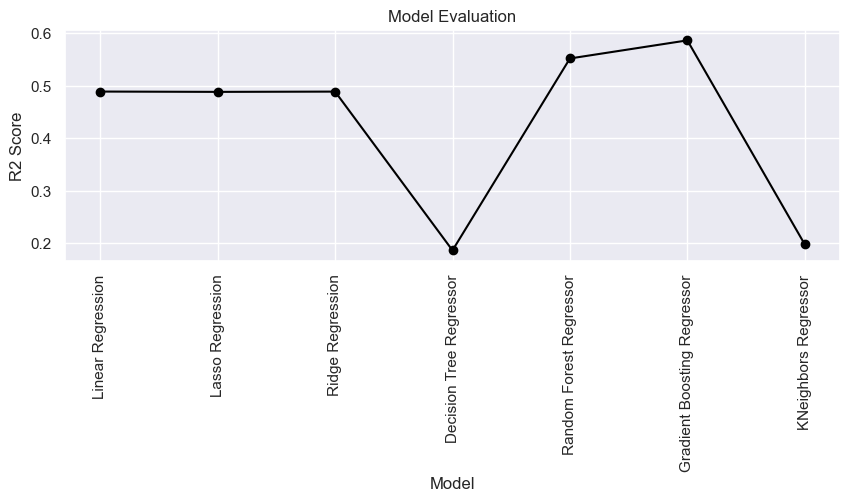

In [433]:
#Plot the model evaluation

plt.figure(figsize=(10,3))
plt.plot( models['Model'],models['R2 Score'], color='black', marker='o')
plt.title('Model Evaluation')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()

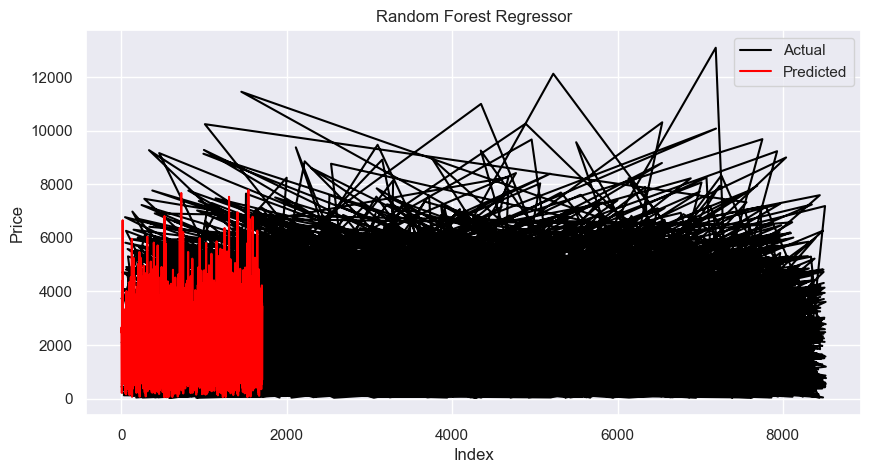

In [434]:
#show the graph for random forest regressor
plt.figure(figsize=(10,5))
plt.plot(Y_train, color='black', label='Actual')
plt.plot(y_pred_RF, color='red', label='Predicted')
plt.title('Random Forest Regressor')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()